# MCMC (Metropolis-Hastings) for FlatLambdaCDM with DESI+CMB

In [1]:
"""""
Aim of this script is to derive the cosmological parameters using combined DESI and CMB data. It uses a MCMC (Metropolis-Hastings) 
method to sample the posterior distribution of the parameters, specifically Hubble constant (H0) and matter density parameter (Omega_m).
The script also includes a log-likelihood function that combines the chi-squared contributions from DESI and CMB data. 
"""""


import sys
sys.path.append('/home/giorgio/Documents/Scuola/Università/Università_di_Genova/IV_ANNO/II_Semestre/Astrofisica Computazionale/ESAME/ToloAstroCosmoLib')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyACC.cosmology.cosmology import FlatLambdaCDM
from pyACC.cosmology.distances import CosmologicalDistances

# I Load data and constants (reuse from previous notebook) ---
file_data = "../DESI+CMB_analysis/data.csv"
data = pd.read_csv(file_data)
data = data.astype(float)
z = data["z_eff"].values
D_V_obs = data["D_V / r_d"].values
D_V_err = data["D_V / r_d_err"].values

# CMB means and covariance data
theta_star_mean = 1.04097/100
w_b_mean = 0.02223
w_bc_mean = 0.14208
Neff = 3.046
cmb_means = np.array([theta_star_mean, w_b_mean, w_bc_mean])
cmb_cov = np.array([
    [0.006621e-9, 0.12444e-9, -1.1929e-9],
    [0.12444e-9, 21.344e-9, -94.001e-9],
    [-1.1929e-9, -94.001e-9, 1488.4e-9]
])
cmb_cov_inv = np.linalg.inv(cmb_cov)

def r_d(w_b, w_bc, Neff=3.046):
    return 147.05 * (w_b/0.02236)**(-0.13) * (w_bc/0.1432)**(-0.23) * (Neff/3.046)**(-0.1)

r_d_val = r_d(w_b_mean, w_bc_mean, Neff)



FileNotFoundError: [Errno 2] No such file or directory: '../DESI+CMB_analysis/data.csv'

In [ ]:
# --- Log-likelihood function ---
def model_cmb_params(H0):
    return np.array([theta_star_mean, w_b_mean, w_bc_mean])

def log_likelihood(params):
    H0, Omega_m = params
    if not (60 < H0 < 80 and 0 < Omega_m < 1):
        return -np.inf
    model = FlatLambdaCDM(H0, Omega_m)
    D_V_model = np.array([CosmologicalDistances(model.H).volume_distance(z_i) for z_i in z])
    chi2_desi = np.sum(((D_V_obs - D_V_model / r_d_val) / D_V_err) ** 2)
    cmb_model = model_cmb_params(H0)
    delta = cmb_model - cmb_means
    chi2_cmb = delta @ cmb_cov_inv @ delta
    return -0.5 * (chi2_desi + chi2_cmb)

In [ ]:
# --- Metropolis-Hastings MCMC ---
nsteps = 1000000 
burnin = 2000
params_init = np.array([78.0, 0.7])
chain = np.zeros((nsteps, 2))
logp = log_likelihood(params_init)
chain[0] = params_init

proposal_cov = np.array([[0.05, 0.0], 
                         [0.0, 0.01]])  # Tune as needed
rng = np.random.default_rng()

for i in range(1, nsteps):
    proposal = rng.multivariate_normal(chain[i-1], proposal_cov)
    logp_prop = log_likelihood(proposal)
    if np.log(rng.uniform()) < logp_prop - logp:
        chain[i] = proposal
        logp = logp_prop
    else:
        chain[i] = chain[i-1]

<>:9: SyntaxWarning: invalid escape sequence '\O'
<>:19: SyntaxWarning: invalid escape sequence '\O'
<>:20: SyntaxWarning: invalid escape sequence '\O'
<>:9: SyntaxWarning: invalid escape sequence '\O'
<>:19: SyntaxWarning: invalid escape sequence '\O'
<>:20: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_433423/834075138.py:9: SyntaxWarning: invalid escape sequence '\O'
  axes[1].set_ylabel("$\Omega_m$")
/tmp/ipykernel_433423/834075138.py:19: SyntaxWarning: invalid escape sequence '\O'
  plt.ylabel('$\Omega_m$')
/tmp/ipykernel_433423/834075138.py:20: SyntaxWarning: invalid escape sequence '\O'
  plt.title("Posterior Samples: $H_0$ vs $\Omega_m$")


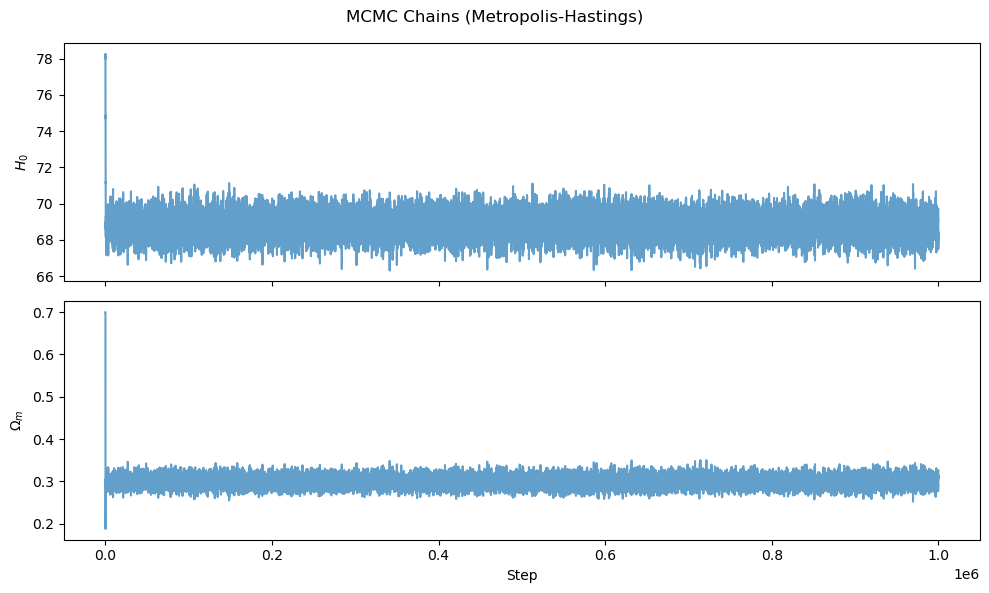

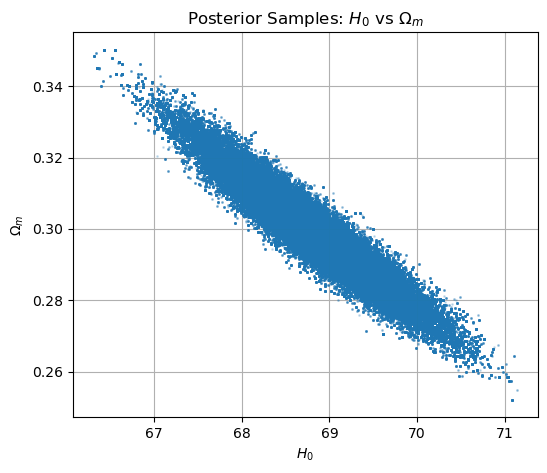

Posterior mean H0: 68.82 ± 0.64
Posterior mean Omega_m: 0.299 ± 0.012


In [ ]:
# I Discard the burn-in
samples = chain[burnin:]

# --- Plot the chains and posterior ---
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axes[0].plot(chain[:, 0], alpha=0.7)
axes[0].set_ylabel("$H_0$")
axes[1].plot(chain[:, 1], alpha=0.7)
axes[1].set_ylabel("$\Omega_m$")
axes[1].set_xlabel("Step")
plt.suptitle("MCMC Chains (Metropolis-Hastings)")
plt.tight_layout()
plt.show()

# Plot posterior samples in parameter space
plt.figure(figsize=(6, 5))
plt.plot(samples[:, 0], samples[:, 1], '.', alpha=0.2, markersize=2)
plt.xlabel("$H_0$")
plt.ylabel('$\Omega_m$')
plt.title("Posterior Samples: $H_0$ vs $\Omega_m$")
plt.grid(True)
plt.show()

# Print mean and std
mean_H0 = np.mean(samples[:, 0])
std_H0 = np.std(samples[:, 0])
mean_Om = np.mean(samples[:, 1])
std_Om = np.std(samples[:, 1])
print(f"Posterior mean H0: {mean_H0:.2f} ± {std_H0:.2f}")
print(f"Posterior mean Omega_m: {mean_Om:.3f} ± {std_Om:.3f}")

## Gelman-Rubin $\hat{R}$ Convergence Diagnostic

The Gelman-Rubin statistic ($\hat{R}$) compares the variance between multiple MCMC to the variance within each chain. Values close to 1 indicate convergence. Here, I split the chain into several sub-chains and compute $\hat{R}$ for each parameter.

In [ ]:
def gelman_rubin(chain, n_splits=4):
    """
    Compute Gelman-Rubin R-hat for each parameter by splitting a single chain into n_splits.
    chain: shape (nsteps, ndim)
    """
    nsteps, ndim = chain.shape
    split_chains = np.array_split(chain, n_splits, axis=0)
    # Ensure all splits have the same length by trimming to the minimum length
    min_len = min(split.shape[0] for split in split_chains)
    split_chains = np.stack([split[:min_len] for split in split_chains])  # shape: (n_splits, min_len, ndim)
    n_splits, n_per, ndim = split_chains.shape
    Rhat = np.zeros(ndim)
    for k in range(ndim):
        chains_k = split_chains[:, :, k]
        mean_per_chain = np.mean(chains_k, axis=1)
        var_per_chain = np.var(chains_k, axis=1, ddof=1)
        B = n_per * np.var(mean_per_chain, ddof=1)
        W = np.mean(var_per_chain)
        var_hat = (1 - 1/n_per) * W + B / n_per
        Rhat[k] = np.sqrt(var_hat / W)
    return Rhat

# Compute R-hat for the chain (after burn-in)
Rhat = gelman_rubin(samples, n_splits=4)
param_labels = [r"$H_0$", r"$\Omega_m$"]
for i, r in enumerate(Rhat):
    if r < 1.03:
        print(f"Converged: {param_labels[i]} R-hat = {r:.5f}")
    else:
        print(f"NOT converged: {param_labels[i]} R-hat = {r:.5f}")
    

Converged: $H_0$ R-hat = 1.00006
Converged: $\Omega_m$ R-hat = 1.00006


## Effective Sample Size (ESS) Calculation

The Effective Sample Size (ESS) estimates the number of independent samples in your MCMC chain, accounting for autocorrelation. Higher ESS means more reliable parameter estimates.

In [ ]:
def autocorr_time(chain, max_lag=1000):
    """Estimate the integrated autocorrelation time for each parameter."""
    n, ndim = chain.shape
    act = np.empty(ndim)
    for k in range(ndim):
        x = chain[:, k] - np.mean(chain[:, k])
        acf = np.correlate(x, x, mode='full')[n-1:] / np.arange(n, 0, -1)
        acf /= acf[0]
        # Only sum positive lags until acf drops below zero or max_lag
        positive = acf[:max_lag][acf[:max_lag] > 0]
        act[k] = 1 + 2 * np.sum(positive[1:])
    return act

# Compute autocorrelation time for each parameter
tau = autocorr_time(samples)

# Compute Effective Sample Size (ESS) for each parameter
n_samples = samples.shape[0]
ESS = n_samples / tau
param_labels = [r"$H_0$", r"$\Omega_m$"]
for i, ess in enumerate(ESS):
    print(f"ESS for {param_labels[i]}: {ess:.1f}")

ESS for $H_0$: 7315.5
ESS for $\Omega_m$: 7736.2


## Plot the evolution of the chain in parameter space

This plot shows the trajectory of the MCMC chain in the ($H_0$, $\Omega_m$) parameter space as the sampler evolves.

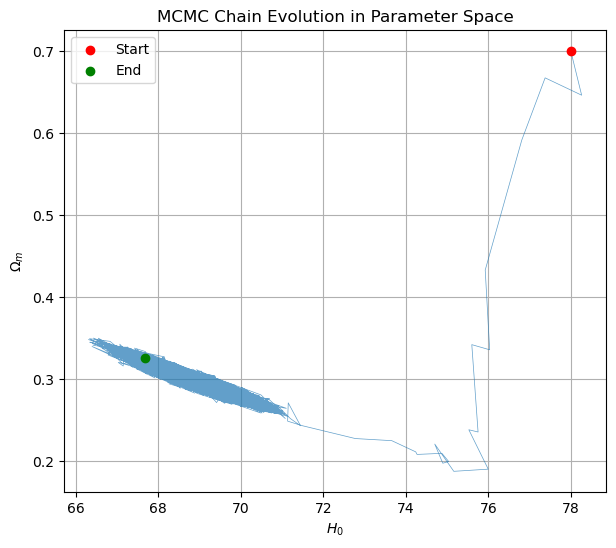

In [ ]:
plt.figure(figsize=(7, 6))
plt.plot(chain[:, 0], chain[:, 1], lw=0.5, alpha=0.7, color='tab:blue')
plt.scatter(chain[0, 0], chain[0, 1], color='red', label='Start', zorder=5)
plt.scatter(chain[-1, 0], chain[-1, 1], color='green', label='End', zorder=5)
plt.xlabel(r"$H_0$")
plt.ylabel(r"$\Omega_m$")
plt.title("MCMC Chain Evolution in Parameter Space")
plt.legend()
plt.grid(True)
plt.show()

## Comparison with Literature: arXiv:2411.12020v1

<div style="background: #f6f8fa; border-left: 4px solid #0366d6; padding: 1em 1.5em; margin-bottom: 1em;">
<b>Paper Reference:</b> <a href="https://arxiv.org/abs/2411.12020v1" target="_blank">arXiv:2411.12020v1</a>  
<b>Table V, Flat ΛCDM, DESI+CMB fit</b>
</div>

| Flat ΛCDM         | My $χ^2$ minimization         |My MCMC sample    | Paper|
|-------------------|-------------------------------|-------------------|----------------------------|
| $H_0$   | $68.851 \pm 0.454 \,\text{km/s/Mpc}$   |$68.82 \pm 0.64 \,\text{km/s/Mpc}$| $67.50 \pm 0.33 \,\text{km/s/Mpc}$              |
| $\Omega_m$        | $0.2980 \pm 0.0943$           | $00.299 \pm 0.012$       | $0.3034 \pm 0.0037$|